In [1]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, AveragePooling2D,Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
import PIL

In [2]:
BATCH_SIZE = 64
IMG_HEIGHT = 180
IMG_WIDTH = 180
VAL_SPLIT = 0.2
SEED = 157
LABELS = 'binary'
DATA_PATH = '/kaggle/input/cat-vs-dogs'

In [3]:
animals = list(os.walk('/kaggle/input/cat-vs-dogs')) 

In [4]:
label_names = animals[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'dog': 0, 'cat': 1}


In [5]:
def dataset(path):
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] 

        for file in (os.listdir(os.path.join(path, folder, folder))):
            path_of_file = os.path.join(os.path.join(path, folder, folder), file)
            # print(path_of_file)
            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('/kaggle/input/cat-vs-dogs')
images, labels = shuffle(images, labels)

100%|██████████| 2/2 [00:41<00:00, 20.57s/it]


In [6]:
images.shape

(5364, 180, 180, 3)

In [7]:
labels[0]

0

In [8]:
# prove that it has been scaled
images[0].max()

0.9137255

In [9]:
size = len(images)
point = int(size*(1-VAL_SPLIT))
train_image = images[0:point+1]
train_label = labels[0:point+1]
val_image = images[point+1:size]
val_label = labels[point+1:size]
print(len(train_image) / size)
print(len(val_image) / size)

0.8001491424310216
0.19985085756897839


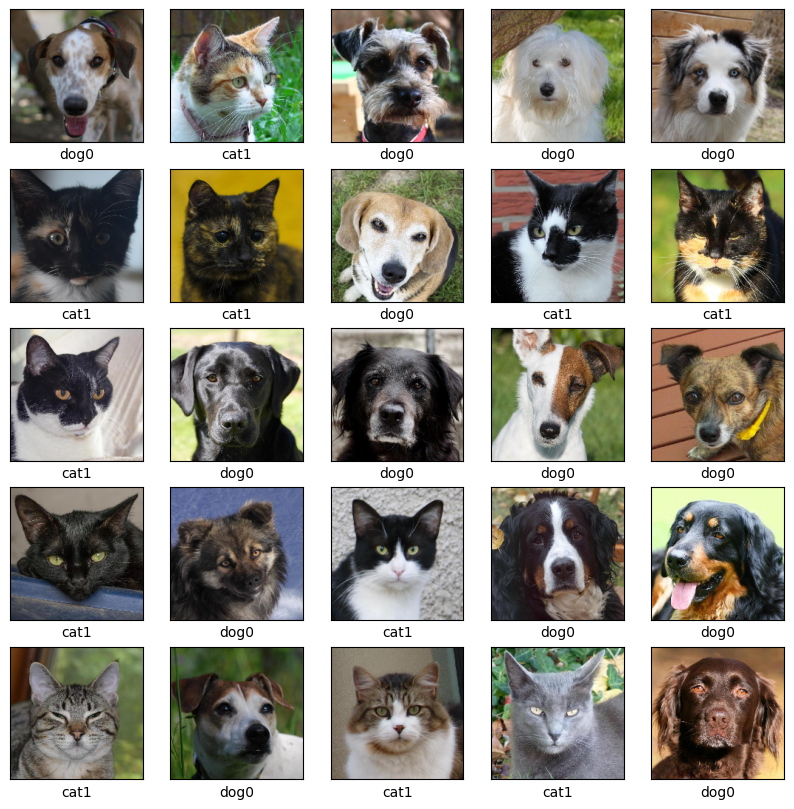

In [10]:
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[i]
    plt.xlabel(str(label_names[labels[i]] + str(labels[i])))
    plt.imshow(data);

In [11]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False, # Not including the Dense Layer
    input_shape = (IMG_HEIGHT,IMG_WIDTH,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
conv_base.trainable = False
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(120,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(images, labels, epochs=5, validation_data=(val_image, val_label))

Epoch 1/5


I0000 00:00:1733178917.746083      74 service.cc:145] XLA service 0x7d935c010320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733178917.746144      74 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733178917.746150      74 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/168 ━━━━━━━━━━━━━━━━━━━━ 47:06 17s/step - accuracy: 0.5000 - loss: 0.7930

I0000 00:00:1733178932.658116      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


168/168 ━━━━━━━━━━━━━━━━━━━━ 52s 211ms/step - accuracy: 0.9010 - loss: 0.2222 - val_accuracy: 0.9963 - val_loss: 0.0068
Epoch 2/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.9928 - loss: 0.0208 - val_accuracy: 0.9981 - val_loss: 0.0050
Epoch 3/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.9918 - loss: 0.0239 - val_accuracy: 0.9981 - val_loss: 0.0031
Epoch 4/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.9898 - loss: 0.0282 - val_accuracy: 0.9991 - val_loss: 0.0029
Epoch 5/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.9938 - loss: 0.0190 - val_accuracy: 1.0000 - val_loss: 0.0012


In [15]:
model.save('PetNet.h5')